In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

(1314, 1980, 3)


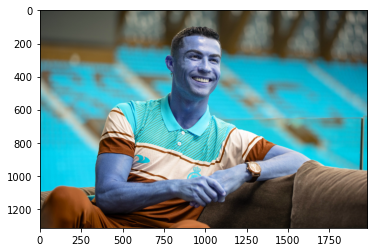

In [2]:
img = cv2.imread('./datasets/cristiano ronaldo/16856385206626.png')
plt.imshow(img)
print(img.shape)

(1314, 1980)


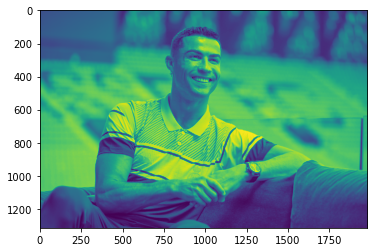

In [3]:
# to conver the image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray)

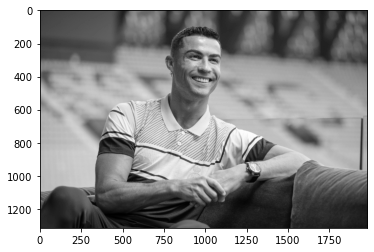

In [4]:
plt.imshow(gray,cmap='gray')

In [5]:
#using harr cascade

In [6]:
face_cascade = cv2.CascadeClassifier('./harrcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./harrcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray,1.3,5)
faces
#to figure out where the face dimensions are there

array([[827, 160, 336, 336]])

In [7]:
#drawing the face
(x,y,w,h) = faces[0]
x,y,w,h

(827, 160, 336, 336)

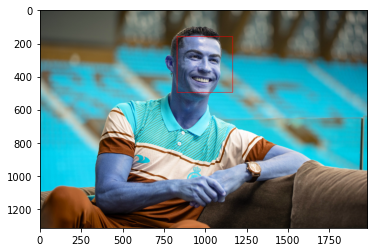

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #drawing the face
plt.imshow(face_img)

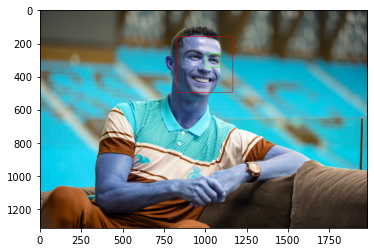

In [9]:
#to draw the face and the eyes
#its called roi - Region Of Intrest
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(225,0,0),2)
    roi_gray = gray[y:y+h,x:x+h]
    roi_color = face_img[y:y+h,x:x+h]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,225,0),2)
plt.figure()
plt.imshow(face_img,cmap='gray')

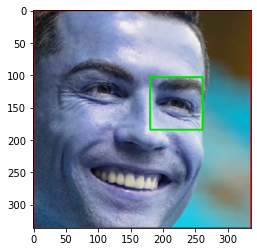

In [10]:
%matplotlib inline
plt.imshow(roi_color,cmap='gray')

In [11]:
# function to crop all images we have, to only keep the roi area, i.e just the face

In [12]:
def get_cropped_img_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+h]
        eye = eye_cascade.detectMultiScale(roi_gray)
        if len(eye)>=2:
            return roi_color

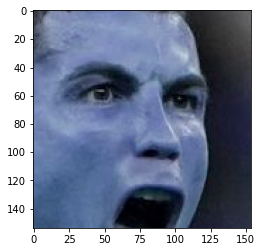

In [13]:
try_img = get_cropped_img_if_2_eyes('./datasets/cristiano ronaldo/.jpg')
plt.imshow(try_img)

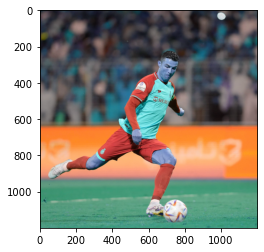

In [14]:
org_false = cv2.imread('./datasets/cristiano ronaldo/1_CR7-Al-Nassr.jpg')
plt.imshow(org_false)

In [15]:
try_img_false = get_cropped_img_if_2_eyes('./datasets/cristiano ronaldo/1_CR7-Al-Nassr.jpg')
try_img_false

In [16]:
# to find names of all folder in current directory

In [17]:
path_to_dir = "./datasets"
path_to_cropped = "./datasets/cropped"

In [18]:
#saving path of all individual sub-folders
import os
img_dirs= []
for entry in os.scandir(path_to_dir):
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['./datasets\\cristiano ronaldo',
 './datasets\\serena williams',
 './datasets\\stone cold steve austin',
 './datasets\\the rock']

In [19]:
#to create a folder in the current directory we are in using code

In [20]:
import shutil
if os.path.exists(path_to_cropped): #to delete if a folder with similar name exists.
    shutil.rmtree(path_to_cropped)
os.mkdir(path_to_cropped)

In [21]:
cropped_img_dir = []
celebrity_file_names_dic = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('\\')[-1]
    celebrity_file_names_dic[celebrity_name]=[]
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_img_if_2_eyes(entry.path)
        if roi_color is not None:
            folder_name = path_to_cropped + celebrity_name
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)
                cropped_img_dir.append(folder_name)
            cropped_filename = celebrity_name + str(count)+".jpg"
            cropped_file_path = folder_name + '\\' + cropped_filename
            
            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dic[celebrity_name].append(cropped_file_path)
            count+=1

In [22]:
#Feature Engineering - Wavelet Transform - considered most effective

In [24]:
import numpy as np
import pywt

In [25]:
def w2d(img,mode='harr',level=1):
    imArray = img
    #Data type conversion
    #convert to Gray scale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_BGR2GRAY)
    #Convert to float
    imArray = np.float32(imArray)
    imArray /= 225;
    #computing the coeffecients
    coeffs = pywt.wavedec2(imArray,mode,level=1)
    #Process coeffs
    coeffs_H = list(coeffs)
    coeffs_H[0]*=0;
    
    #reconstruction
    imArray_H = pywt.waverec2(coeffs_H,mode)
    imArray_H*=225
    imArray = np.uint8(imArray)
    return imArray_H

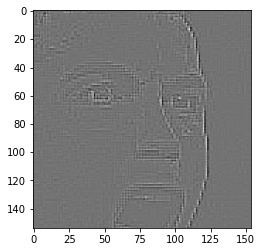

In [26]:
im_har = w2d(try_img,'db1',5)
plt.imshow(im_har,cmap='gray')

In [27]:
#now create wavelet transform images for all images in cropped folders

In [28]:
#vertically stack the wavelet image and raw image.

In [29]:
#numbering celebrities
dic_counts = {}
j = 0
for i in celebrity_file_names_dic:
    dic_counts[i] = dic_counts.get(i,0)+j
    j+=1
dic_counts

{'cristiano ronaldo': 0,
 'serena williams': 1,
 'stone cold steve austin': 2,
 'the rock': 3}

In [30]:
X = []
Y = []
for celebrity_name, training_files in celebrity_file_names_dic.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw = cv2.resize(img,(32,32))
        img_wav = w2d(img,'db1',5)
        scaled_imgwav = cv2.resize(img_wav,(32,32))
        v_stackedimage = np.vstack((scaled_raw.reshape(32*32*3,1),scaled_imgwav.reshape(32*32,1)))
        X.append(v_stackedimage)
        Y.append(dic_counts[celebrity_name])

In [31]:
len(X)

430

In [32]:
X[0]

array([[53.        ],
       [58.        ],
       [63.        ],
       ...,
       [ 0.15258908],
       [-0.4042979 ],
       [ 0.6584459 ]], dtype=float32)

In [33]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(430, 4096)

# Data is ready for model training. Data Cleaning is Finished

In [34]:
## SVM + rbf kernel + heurestic tuning

In [35]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [36]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,random_state=0)

In [37]:
pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=10))]) #to perform both sacling and fitting in single go

In [38]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [39]:
pipe.score(x_test,y_test)

0.8240740740740741

In [40]:
len(x_test)

108

In [41]:
print(classification_report(y_test,pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93        33
           1       0.88      0.64      0.74        22
           2       1.00      0.43      0.60        14
           3       0.74      0.95      0.83        39

    accuracy                           0.82       108
   macro avg       0.88      0.75      0.77       108
weighted avg       0.85      0.82      0.81       108



## Using GridSearchCV to hypertune parameters, by trying out diff models with diff parameters. To find best model with best fine tuned parameters

In [42]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [43]:
model_params ={
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params':{
            'svc__C':[1,10,100,1000],
            'svc__kernel':['rbf','linear']
        }
    },
    'random_froest_classifier':{
        'model':RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators':[1,5,10]
        }
    },
    'logisticregression':{
        'model':LogisticRegression(solver = 'liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C':[1,5,10]
        }
    }
}

In [44]:
scores = []
best_estimators = {}
import pandas as pd
for algo,mp in model_params.items():
    pipe = make_pipeline(StandardScaler(),mp['model'])
    clf  = GridSearchCV(pipe,mp['params'],cv=5,return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model':algo,
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
data = pd.DataFrame(scores,columns=['model','best_score','best_params'])
data

,model,best_score,best_params
0,svm,0.770337,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_froest_classifier,0.617885,{'randomforestclassifier__n_estimators': 10}
2,logisticregression,0.770144,{'logisticregression__C': 1}


In [45]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_froest_classifier': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logisticregression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [46]:
best_estimators['svm'].score(x_test,y_test)

0.8611111111111112

In [47]:
best_estimators['logisticregression'].score(x_test,y_test)

0.8148148148148148

In [48]:
best_clf = best_estimators['svm']

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,best_clf.predict(x_test))
cm

array([[32,  0,  0,  1],
       [ 3, 16,  0,  3],
       [ 0,  1,  8,  5],
       [ 2,  0,  0, 37]], dtype=int64)

Text(51.0, 0.5, 'Truth')

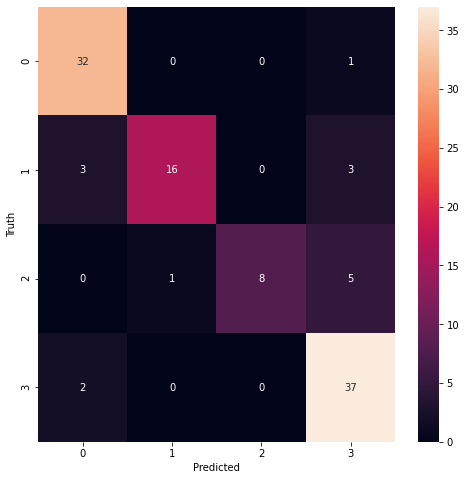

In [50]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [51]:
dic_counts

{'cristiano ronaldo': 0,
 'serena williams': 1,
 'stone cold steve austin': 2,
 'the rock': 3}

## Save the model

In [52]:
!pip install joblib

In [53]:
import joblib
#saving the model as a pickle file
joblib.dump(best_clf,'saved_model.pkl')

['saved_model.pkl']

## Save the class_dic

In [54]:
import json
with open("class_dic.json",'w') as f:
    f.write(json.dumps(dic_counts))